In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Python Libraries

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import cv2

from joblib import dump, load

#Import all the machine learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Use train_test_split to split the data into train and test
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle
from progressbar import ProgressBar

# 1. Load Data


In [3]:
def parse_data(datadir):
    img_list = []
    ID_list = []
    for root, directories, filenames in os.walk(datadir):  #root: median/1
        for filename in filenames:
            if filename.endswith('.jpg'):
                filei = os.path.join(root, filename)
                img_list.append(filei)
                ID_list.append(root.split('/')[-1])


    # construct a dictionary, where key and value correspond to ID and target
    uniqueID_list = list(set(ID_list))
    class_n = len(uniqueID_list)
    target_dict = dict(zip(uniqueID_list, range(class_n)))
    label_list = [target_dict[ID_key] for ID_key in ID_list]

    img_list, label_list = shuffle(img_list, label_list)
    
    print(f"#Images = {len(img_list)}, #Labels = {len(set(label_list))}")
    return img_list, label_list, class_n

In [42]:
#Upload the images as grayscale and flatten it
#The images are of different sizes so resize all the images to be 256*256
def upload_images(image_paths, new_size=256):
    dataset = []
    hog_images = []
    original_images = []

    pbar = ProgressBar()
    for path in pbar(image_paths):
        #The 0 indicate that cv2.imread read the image in grayscale
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (new_size, new_size))
        
        #img = img.flatten()
        original_images.append(img)

        hog_features, img = hog(
          img, pixels_per_cell=(20,20),
          cells_per_block=(10,10),
          orientations=10,
          visualize=True,
          block_norm='L2')
        
        
        hog_images.append(img)
        dataset.append(hog_features)
    
    dataset = np.array(dataset)

    print(f"Flatten Image New Size = {new_size} * {new_size} = {new_size**2}\n")
    print(f"Dataset Shape = {dataset.shape}")
    
    return original_images, hog_images, dataset

In [44]:
#Load the train, validation, and test dataset images paths and labels.
root_path = "/content/drive/MyDrive/Data/ICS-381_Project/dataset_mix"

split_factor = 0.7

img_list, label_list, classes = parse_data(root_path)

#Split the data into train and validation datasets
train_list, val_list, train_label, val_label = train_test_split(img_list, label_list, train_size=split_factor, shuffle=True)

print(f"Split Factor  = {split_factor}")
print(f"train_dataset = {train_list.__len__()}")
print(f"val_dataset   = {val_list.__len__()}")

#Images = 7553, #Labels = 2
Split Factor  = 0.7
train_dataset = 5287
val_dataset   = 2266


In [ ]:
train_images, train_hog_images, train_dataset = upload_images(train_list)

100% (5287 of 5287) |####################| Elapsed Time: 0:33:51 Time:  0:33:51


Flatten Image New Size = 256 * 256 = 65536

Dataset Shape = (5287, 9000)


In [45]:
val_images, val_hog_images, val_dataset = upload_images(val_list)

100% (2266 of 2266) |####################| Elapsed Time: 0:10:03 Time:  0:10:03


Flatten Image New Size = 256 * 256 = 65536

Dataset Shape = (2266, 9000)


# 2. Explore The Data
The data consists of 1376 images divide into three dataset which are train datast, validation dataset, and test dataset. The dataset has two classes either with a mask or without a mask.

In [ ]:
def plot_faces(pixels):
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[i].reshape(256, 256), cmap='gray')
    plt.show()

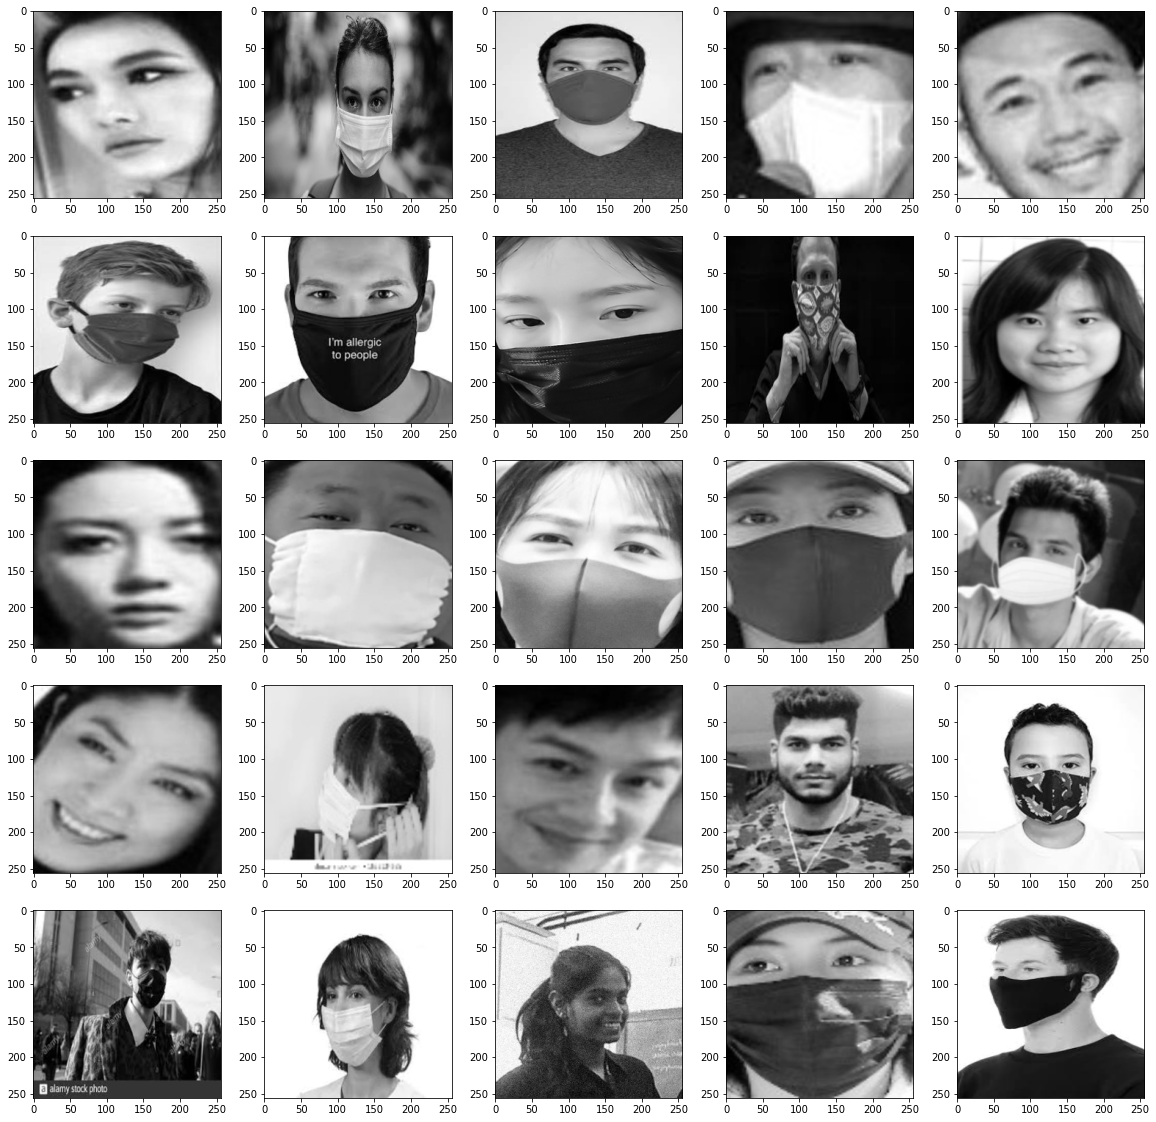

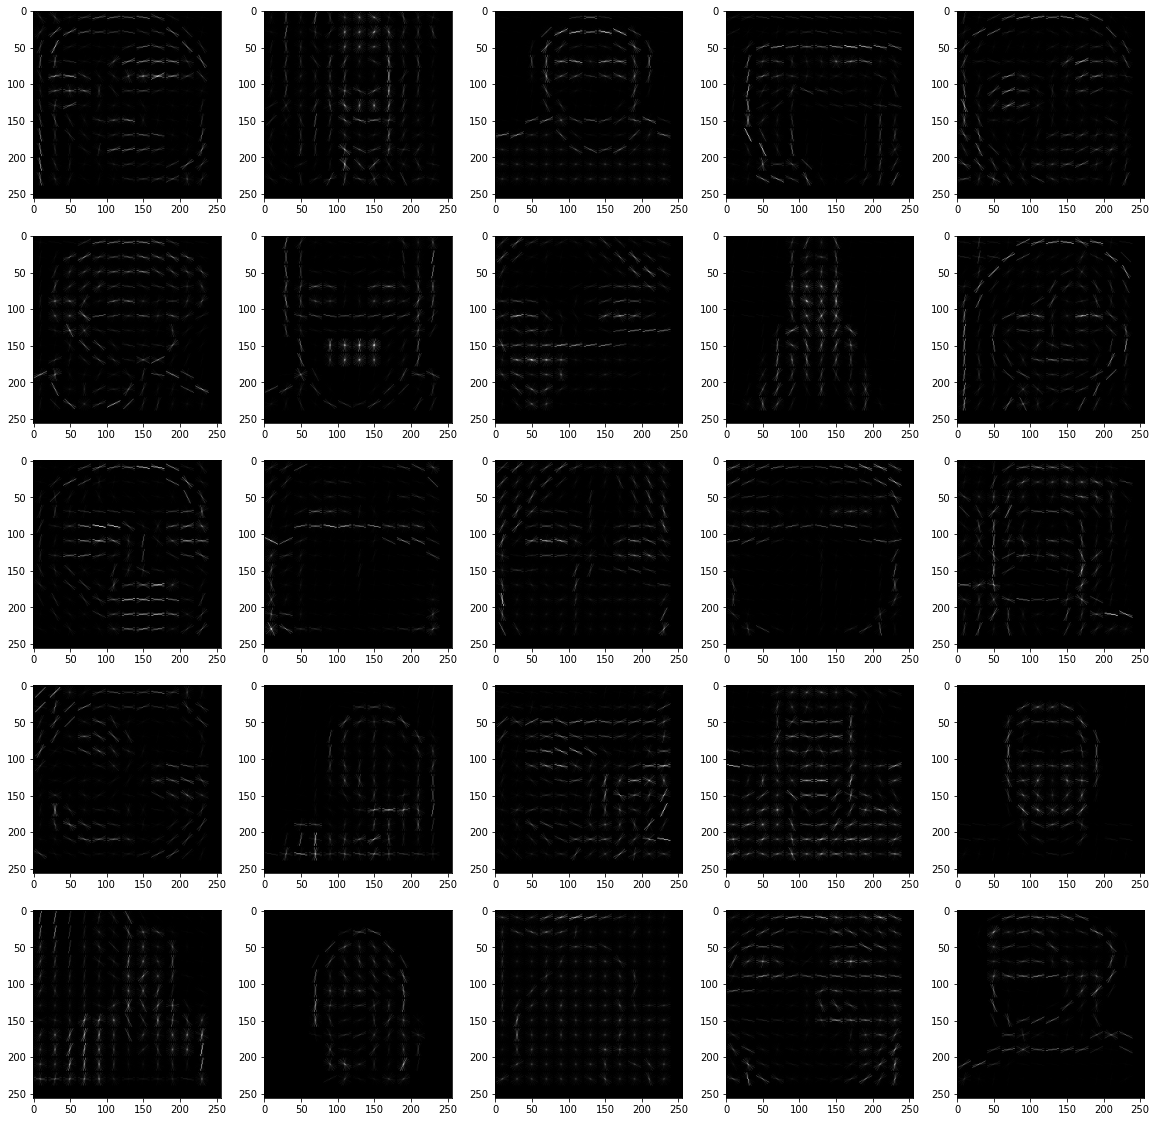

Labels: [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1]


In [ ]:
plot_faces(val_images[0:26])
plot_faces(val_hog_images[0:26])
print(f"Labels: {val_label[0:26]}")

# 4. Models

### 4.1 Deciding the Best Model using Cross-Validation

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True)

### a) Naive Bayes

In [ ]:
clf = GaussianNB()

scoring = "accuracy"

score = cross_val_score(clf, train_dataset, train_label, cv=k_fold, n_jobs=1, scoring=scoring)

print(f"Accuracy for all the 5 folds = {score}\n")
print(f"Mean Accuracy = {round(np.mean(score)*100, 2)}")

Accuracy for all the 5 folds = [0.74007561 0.73440454 0.71239357 0.74172185 0.72942289]

Mean Accuracy = 73.16


### b) Neural Network

In [ ]:
clf = MLPClassifier(max_iter=500)

scoring = "accuracy"

score = cross_val_score(clf, train_dataset, train_label, cv=k_fold, n_jobs=1, scoring=scoring)

print(f"Accuracy for all the 5 folds = {score}\n")
print(f"Mean Accuracy = {round(np.mean(score)*100, 2)}")

Accuracy for all the 5 folds = [0.84120983 0.84310019 0.85241249 0.83065279 0.8268685 ]

Mean Accuracy = 83.88


### c) Decision Tress

In [ ]:
clf = DecisionTreeClassifier()

scoring = "accuracy"

score = cross_val_score(clf, train_dataset, train_label, cv=k_fold, n_jobs=1, scoring=scoring)

print(f"Accuracy for all the 5 folds = {score}\n")
print(f"Mean Accuracy = {round(np.mean(score)*100, 2)}")

Accuracy for all the 5 folds = [0.73913043 0.72306238 0.7256386  0.73320719 0.72753075]

Mean Accuracy = 72.97


### d) Random Forest

In [ ]:
clf = RandomForestClassifier()

scoring = "accuracy"

score = cross_val_score(clf, train_dataset, train_label, cv=k_fold, n_jobs=1, scoring=scoring)

print(f"Accuracy for all the 5 folds = {score}\n")
print(f"Mean Accuracy = {round(np.mean(score)*100, 2)}")

Accuracy for all the 5 folds = [0.82797732 0.84310019 0.83727531 0.8666036  0.8448439 ]

Mean Accuracy = 84.4


### e) Support Vector Classifier

In [ ]:
clf = SVC()

scoring = "accuracy"

score = cross_val_score(clf, train_dataset, train_label, cv=k_fold, n_jobs=1, scoring=scoring)

print(f"Accuracy for all the 5 folds = {score}\n")
print(f"Mean Accuracy = {round(np.mean(score)*100, 2)}")

Accuracy for all the 5 folds = [0.8563327  0.8705104  0.86849574 0.84295175 0.85146641]

Mean Accuracy = 85.8


### 4.1 Best Model (Random Forest Classifier)

In [ ]:
best_model = SVC()

#Train the model using the trian_dataset
best_model.fit(train_dataset, train_label)

#Test the model and get the accuracy using the val_dataset
accuracy = best_model.score(val_dataset, val_label)

print(f"Support Vector Machine Accuracy = {round(accuracy,2)*100}%")

Support Vector Machine Accuracy = 86.0%


# 5. Test Model

In [ ]:
def test_model(model, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))

    hog_features, hog_img = hog(
              img, pixels_per_cell=(20,20),
              cells_per_block=(10,10),
              orientations=10,
              visualize=True,
              block_norm='L2')
    
    hog_features = hog_features.reshape(1, -1)

    pred_labels = model.predict(hog_features)
    
    plt.imshow(img, cmap="gray")
    plt.show()

    plt.imshow(hog_img, cmap='gray')
    plt.show()

    print(pred_labels)

    if pred_labels == 0:
        print(f"Prediction: with mask")
    else:
        print(f"Prediction: without mask")

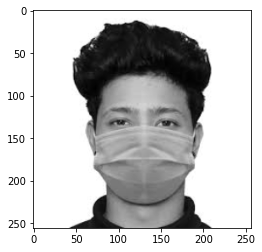

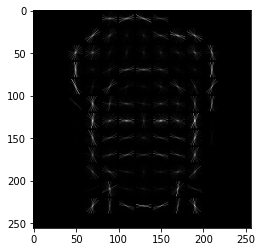

[0]
Prediction: with mask


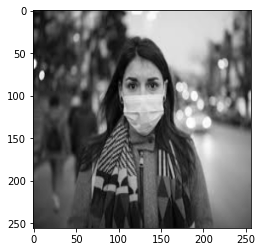

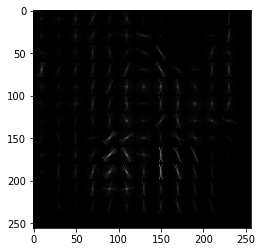

[0]
Prediction: with mask


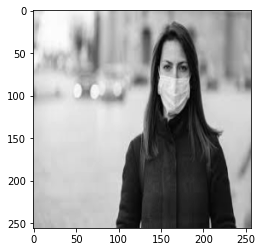

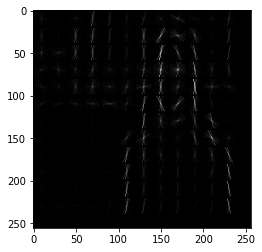

[0]
Prediction: with mask


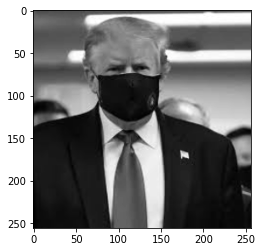

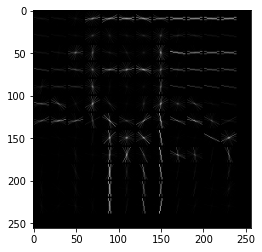

[0]
Prediction: with mask


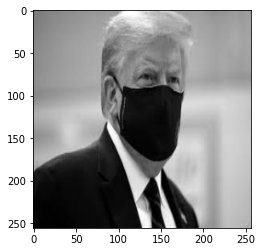

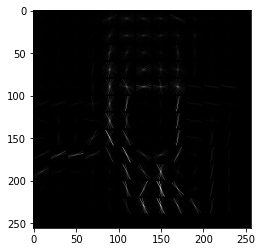

[0]
Prediction: with mask


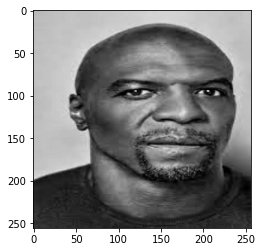

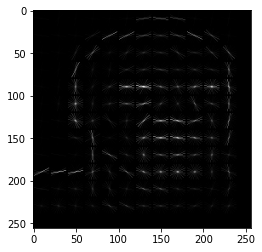

[1]
Prediction: without mask


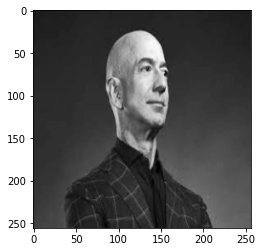

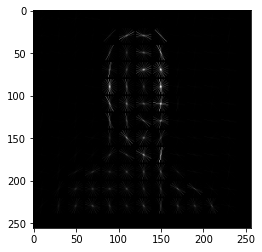

[0]
Prediction: with mask


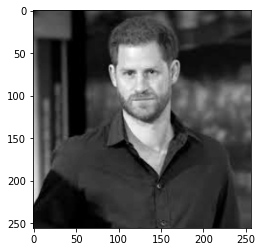

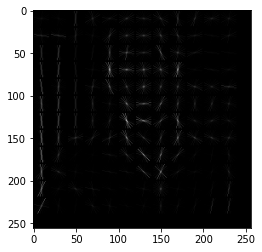

[0]
Prediction: with mask


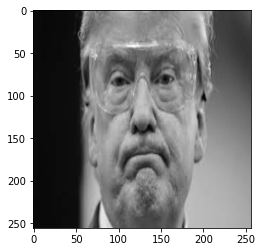

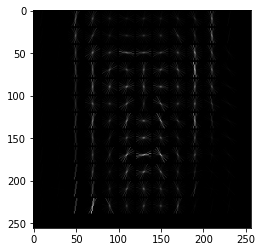

[1]
Prediction: without mask


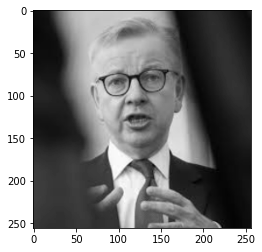

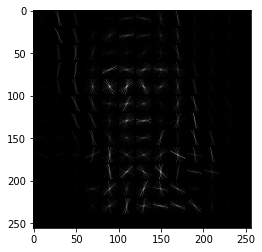

[0]
Prediction: with mask


In [ ]:
paths = ["/content/drive/MyDrive/Data/ICS-381_Project/with_mask1.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask2.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask3.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask4.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask5.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask1.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask2.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask3.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask4.jfif",
         "/content/drive/MyDrive/Data/ICS-381_Project/without_mask5.jfif"]

for path in paths:
    test_model(best_model, path)

# 6. Save the Model

In [ ]:
sklearn_model = dump(best_model, "/content/drive/MyDrive/Models/ICS-381_Project/sklearn_model/model.joblib")

# 7. Load the Model

In [ ]:
loaded_model = load("/content/drive/MyDrive/Models/ICS-381_Project/sklearn_model/model.joblib")

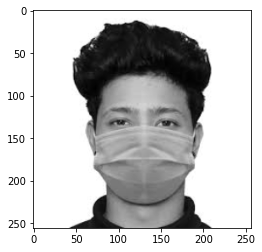

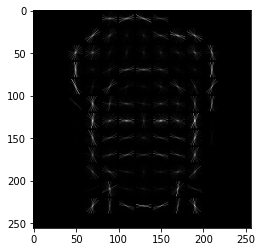

[0]
Prediction: with mask


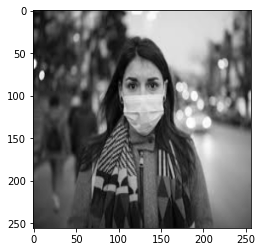

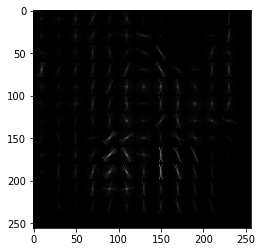

[0]
Prediction: with mask


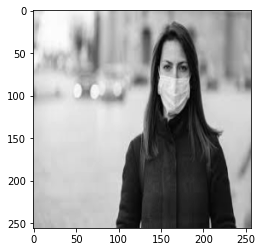

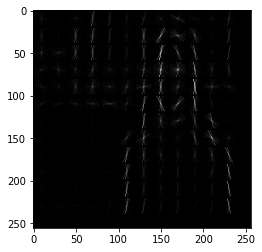

[0]
Prediction: with mask


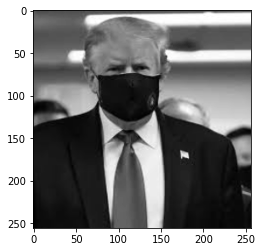

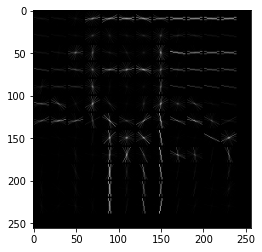

[0]
Prediction: with mask


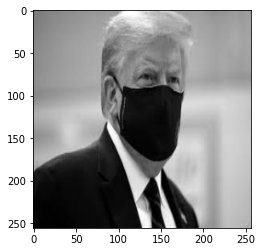

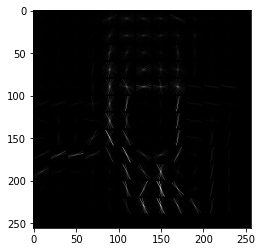

[0]
Prediction: with mask


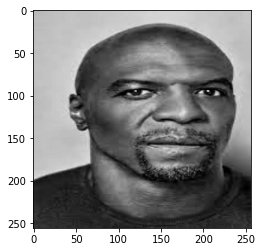

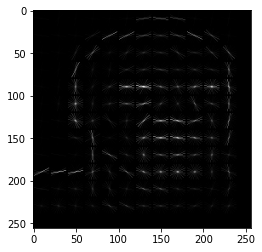

[1]
Prediction: without mask


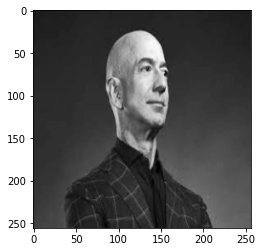

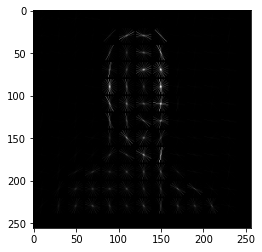

[0]
Prediction: with mask


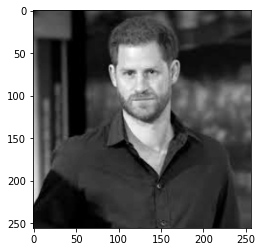

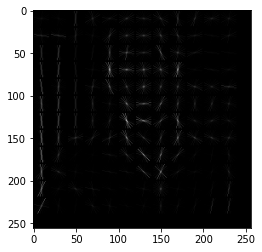

[0]
Prediction: with mask


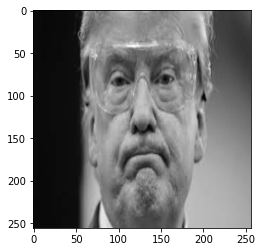

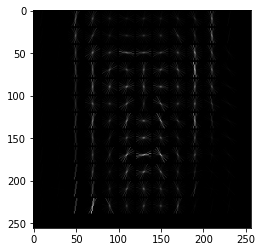

[1]
Prediction: without mask


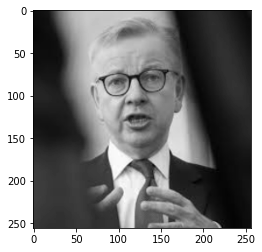

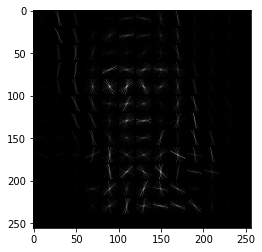

[0]
Prediction: with mask


In [ ]:
paths = ["/content/drive/MyDrive/Data/ICS-381_Project/with_mask1.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask2.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask3.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask4.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask5.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask1.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask2.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask3.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask4.jfif",
         "/content/drive/MyDrive/Data/ICS-381_Project/without_mask5.jfif"]

for path in paths:
    test_model(loaded_model, path)